In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import random

In [34]:
class TempMemoryNet:
    def __init__(self, size, T):
        plt.close('all')

        self.size = size
        self.T = T
        self.start = np.full((size, size), -1)
        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.out = widgets.Output()
        self.button = widgets.Button(description="Run Recognition")
        self.button.on_click(lambda b: self.recall(4,self.T))
        self.EnergyArray = []
        #self.button.on_click(self.show_array)

        A_mem = np.loadtxt("memory_pattern_A.csv", delimiter=",", dtype=int)
        B_mem = np.loadtxt("memory_pattern_B.csv", delimiter=",", dtype=int)
        C_mem = np.loadtxt("memory_pattern_C.csv", delimiter=",", dtype=int)
        D_mem = np.loadtxt("memory_pattern_D.csv", delimiter=",", dtype=int)
        A = A_mem.flatten()
        B = B_mem.flatten()
        C = C_mem.flatten()
        D = D_mem.flatten()

        # Compute interaction matrix with sum of outer products sum(si(m)*sj(m))
        W = np.outer(A, A) + np.outer(B, B) + np.outer(C, C) + np.outer(D, D)
        np.fill_diagonal(W, 0)  # no self-connections

        # Save for use in energy calculation
        self.interaction = W
        
        # Drawing state
        self.is_drawing = False
        self.last_cell = None  # To avoid toggling the same cell multiple times per drag

        # Connect events
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)

        self.update_plot()

    def on_press(self, event):
        if event.inaxes == self.ax:
            self.is_drawing = True
            self.toggle_or_draw(event, toggle=True)

    def on_motion(self, event):
        if self.is_drawing and event.inaxes == self.ax:
            self.toggle_or_draw(event, toggle=False)

    def on_release(self, event):
        self.is_drawing = False
        self.last_cell = None

    def toggle_or_draw(self, event, toggle):
        x = int(round(event.xdata))
        y = int(round(event.ydata))
        if 0 <= x < self.size and 0 <= y < self.size:
            i, j = self.size - 1 - y, x
            cell = (i, j)
            if toggle:
                # Click toggles between 1 and -1
                self.start[i, j] = -1 if self.start[i, j] == 1 else 1
                self.update_plot()
            else:
                # Drag sets to 1 (only if it's not already and not repeated)
                if cell != self.last_cell and self.start[i, j] != 1:
                    self.start[i, j] = 1
                    self.update_plot()
                    self.last_cell = cell

    def update_plot(self):
        self.ax.clear()
        y, x = np.where(self.start == 1)
        self.ax.scatter(x, self.size - 1 - y, color='black', marker='o')

        self.ax.set_xlim(-0.5, self.size - 0.5)
        self.ax.set_ylim(-0.5, self.size - 0.5)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_aspect('equal')
        for spine in self.ax.spines.values():
            spine.set_visible(False)
        self.ax.grid(True)
        self.fig.canvas.draw_idle()

    def show_array(self, _=None):
        with self.out:
            clear_output(wait=True)
            display(self.button)
            print("Memory Array (1s = dots, -1s = empty):\n")
            print(self.start)
            
    def EnergyValue(self, matrix):

        state = matrix.flatten()
        return -(1/3) * np.dot(state, np.dot(self.interaction, state))

        
    def recall(self, iterations, T):
        state = self.start.flatten()
        for _ in range(iterations):
            indices = list(range(len(state)))
            random.shuffle(indices)
            for val in indices:
                delta_E =  (2/3)*state[val] * np.dot(self.interaction[val], state)
                #print(delta_E)
                self.EnergyArray.append(self.EnergyValue(state))

                if delta_E <= 0:
                    state[val] *= -1

                else:
                    r = random.random()
                    if r <= np.exp(-1*abs(delta_E)/T):
                        state[val] *= -1

        self.start = state.reshape((self.size, self.size))
        self.update_plot()
                    
    def interface(self):
        layout = widgets.VBox([
            self.button,  # Top button
            self.out  # And any output below that
        ])
        display(layout)

In [35]:
def LoadMemory():
    A_mem = np.loadtxt("memory_pattern_A.csv", delimiter=",", dtype=int)
    B_mem = np.loadtxt("memory_pattern_B.csv", delimiter=",", dtype=int)
    C_mem = np.loadtxt("memory_pattern_C.csv", delimiter=",", dtype=int)
    D_mem = np.loadtxt("memory_pattern_D.csv", delimiter=",", dtype=int)
    A = A_mem.flatten()
    B = B_mem.flatten()
    C = C_mem.flatten()
    D = D_mem.flatten()

    # Compute interaction matrix with sum of outer products sum(si(m)*sj(m))
    W = np.outer(A, A) + np.outer(B, B) + np.outer(C, C) + np.outer(D, D)
    np.fill_diagonal(W, 0)
    return W

In [36]:
class DAQMemoryNet:
    def __init__(self, W, T, Matrix): #matrix should be a 10X10 array of 1s and -1s representing the pattern to be recognised
        plt.close('all')
        self.size = 10
        self.T = T
        self.start = Matrix.copy()
        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.out = widgets.Output()
        self.interaction = W
        self.EnergyArray = []
        
    def update_plot(self):
        self.ax.clear()
        y, x = np.where(self.start == 1)
        self.ax.scatter(x, self.size - 1 - y, color='black', marker='o')

        self.ax.set_xlim(-0.5, self.size - 0.5)
        self.ax.set_ylim(-0.5, self.size - 0.5)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_aspect('equal')
        for spine in self.ax.spines.values():
            spine.set_visible(False)
        self.ax.grid(True)
        self.fig.canvas.draw_idle()

    def show_array(self, _=None):
        with self.out:
            clear_output(wait=True)
            display(self.button)
            print("Memory Array (1s = dots, -1s = empty):\n")
            print(self.start)
            
    def EnergyValue(self, flatmatrix):
        return -(2/3) * np.dot(flatmatrix, np.dot(self.interaction, flatmatrix))

    def recall(self, iterations):
        state = self.start.flatten()
        for _ in range(iterations):
            indices = list(range(len(state)))
            random.shuffle(indices)
            for val in indices:
                delta_E = (2/3)*state[val] * np.dot(self.interaction[val], state)
                self.EnergyArray.append(self.EnergyValue(state))
                if delta_E <= 0:
                    state[val] *= -1
                else:
                    r = random.random()
                    if r <= np.exp(-1*abs(delta_E)/self.T):
                        state[val] *= -1               
                
        self.start = state.reshape((self.size, self.size))

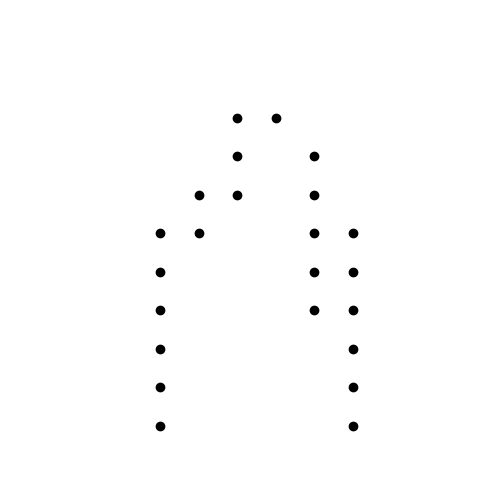

In [246]:
if __name__ == "__main__":
    %matplotlib widget
    test = TempMemoryNet(10,0.001)
    test.start = np.loadtxt("FalseMinPatternStart4.csv", delimiter=",", dtype=int)
    test.update_plot()
    test.interface()


In [243]:
#np.savetxt("FalseMinPattern3-2.csv", test.start, fmt="%d", delimiter=",")

In [244]:
test.EnergyValue(test.start)

-3253.333333333333

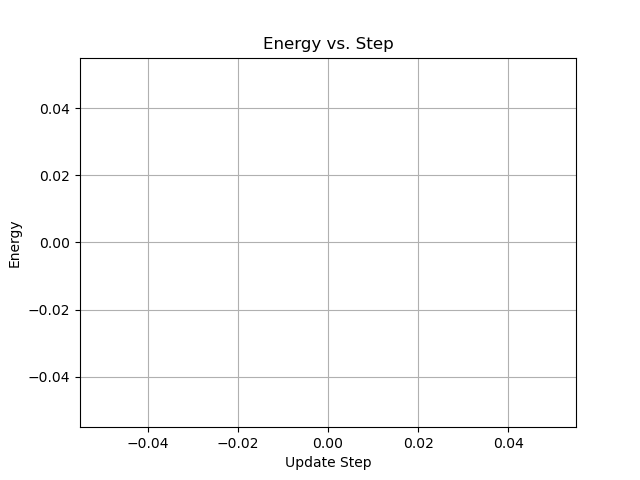

In [38]:

plt.figure()
plt.plot(test.EnergyArray)
plt.xlabel("Update Step")
plt.ylabel("Energy")
plt.title("Energy vs. Step")
plt.grid(True)
plt.show()

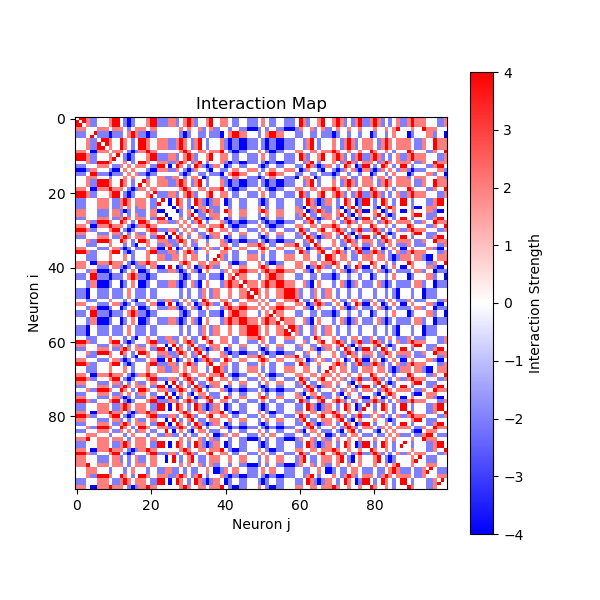

In [87]:
if __name__ == "__main__":

    # Load and plot
    W = LoadMemory()
    plt.figure(figsize=(6, 6))
    plt.imshow(W, cmap='bwr', interpolation='nearest')
    plt.colorbar(label='Interaction Strength')
    plt.title("Interaction Map")
    plt.xlabel("Neuron j")
    plt.ylabel("Neuron i")
    #plt.savefig("4 Memory Interaction Map.png")
    plt.show()

In [10]:
# Creating a random list of pairs for neuron change order so I am consistant 

x = np.arange(10)
y = np.arange(10)
indices = []
for i in x:
    for j in y:
        thistuple = (i,j)
        indices.append(thistuple)
random.shuffle(indices)

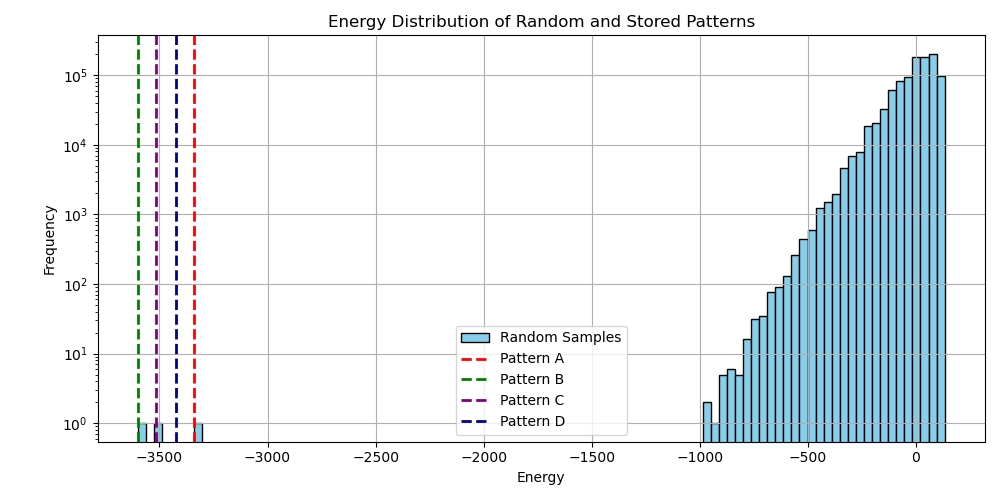

In [255]:
# Load patterns (assumes files are 10x10 with values -1 and 1)
A = np.loadtxt("memory_pattern_A.csv", delimiter=",", dtype=int).flatten()
B = np.loadtxt("memory_pattern_B.csv", delimiter=",", dtype=int).flatten()
C = np.loadtxt("memory_pattern_C.csv", delimiter=",", dtype=int).flatten()
D = np.loadtxt("memory_pattern_D.csv", delimiter=",", dtype=int).flatten()
# Create interaction matrix W using Hebbian rule
W = np.outer(A, A) + np.outer(B, B) + np.outer(C, C) + np.outer(D, D)
np.fill_diagonal(W, 0)

# Function to compute energy of a state
def compute_energy(state, W):
    return -(1/3) * np.dot(state, np.dot(W, state))

# Generate random patterns
n_samples = 1000000
random_states = np.random.choice([-1, 1], size=(n_samples, 100))

# Include true patterns
all_states = np.vstack([random_states, A, B, C])

# Compute energies
energies = np.array([compute_energy(s, W) for s in all_states])

# Find A, B, C energies
E_A = compute_energy(A, W)
E_B = compute_energy(B, W)
E_C = compute_energy(C, W)
E_D = compute_energy(D, W)
# Plot an energy histogram
plt.figure(figsize=(10, 5))
plt.hist(energies, bins=100, color='skyblue', edgecolor='black', label='Random Samples')
plt.axvline(E_A, color='red', linestyle='--', linewidth=2, label='Pattern A')
plt.axvline(E_B, color='green', linestyle='--', linewidth=2, label='Pattern B')
plt.axvline(E_C, color='purple', linestyle='--', linewidth=2, label='Pattern C')
plt.axvline(E_D, color='darkblue', linestyle='--', linewidth=2, label='Pattern D')
plt.title("Energy Distribution of Random and Stored Patterns")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.savefig('Energy Histogram 4 patterns')
plt.show()


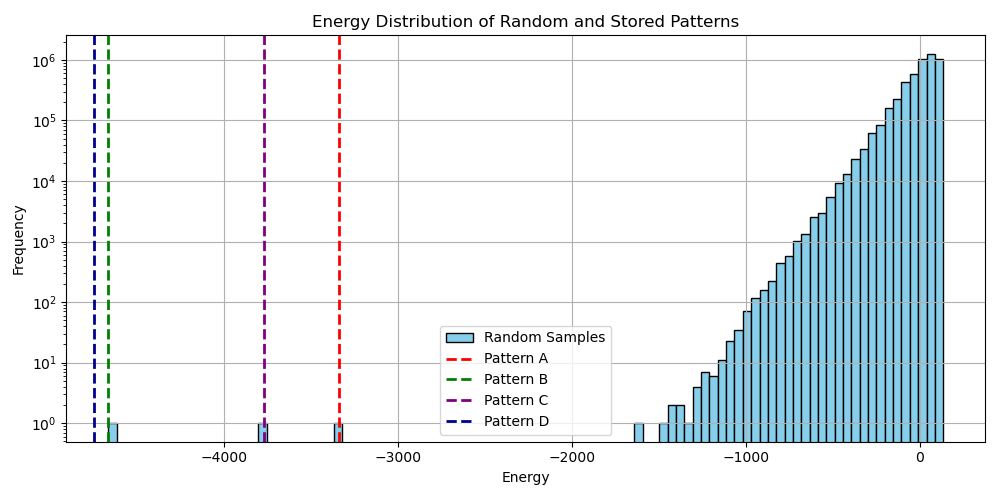

In [58]:
#Distance between patterns
A_mem = np.loadtxt("memory_pattern_A.csv", delimiter=",", dtype=int)
B_mem = np.loadtxt("memory_pattern_B.csv", delimiter=",", dtype=int)
C_mem = np.loadtxt("memory_pattern_C.csv", delimiter=",", dtype=int)
D_mem = np.loadtxt("memory_pattern_D.csv", delimiter=",", dtype=int)
Random =  np.random.choice([-1, 1], size=(10, 10))
A = A_mem.flatten()
B = B_mem.flatten()
C = C_mem.flatten()
D = D_mem.flatten()
Rand = Random.flatten()
Alm_C = np.array(
    [[-1, -1, -1, -1, -1,  1,  1,  1,  1, -1],
     [-1, -1,  1,  1,  1,  1,  1,  1,  1, -1],
     [-1, -1,  1,  1,  1, -1, -1,  1,  1, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1, -1, -1,  1, -1,  1, -1, -1, -1, -1],
     [-1, -1,  1,  1, -1, -1, -1, -1, -1, -1],
     [-1, -1,  1, -1, -1, -1, -1, -1, -1, -1],
     [-1, -1,  1, -1,  1, -1, -1,  1,  1, -1],
     [-1, -1, -1,  1, -1,  1,  1,  1,  1, -1],
     [-1, -1, -1,  1,  1,  1,  1,  1,  1, -1]]
)
Almost_C = Alm_C.flatten()
#Hamming Distances
AtoB = 0
AtoC = 0
BtoC = 0
AtoD = 0
BtoD = 0
CtoD = 0
AtoRandom = 0
BtoRandom = 0
CtoRandom = 0
#Distances to almost C
AtoAlC = 0
BtoAlC = 0
CtoAlC = 0
for i in range(100):    
    AtoB += (A[i]-B[i])**2
    AtoC += (A[i]-C[i])**2
    BtoC += (B[i]-C[i])**2
    AtoD += (A[i]-D[i])**2
    BtoD += (B[i]-D[i])**2
    CtoD += (C[i]-D[i])**2
    AtoRandom += (A[i] - Rand[i])**2 
    BtoRandom +=(B[i] - Rand[i])**2 
    CtoRandom +=(C[i] - Rand[i])**2 
    AtoAlC +=(A[i] - Almost_C[i])**2 
    BtoAlC +=(B[i]-Almost_C[i])**2
    CtoAlC +=(C[i]-Almost_C[i])**2
    
AtoB *= 1/100
AtoC *= 1/100
BtoC *= 1/100
AtoD *= 1/100
BtoD *= 1/100
CtoD *= 1/100
AtoRandom *= 1/100
BtoRandom *= 1/100
CtoRandom *= 1/100
AtoAlC *= 1/100
BtoAlC *= 1/100
CtoAlC *= 1/100
print(f"Distance from A to B = {AtoB}, \n distance from A to C = {AtoC}, \n distance from B to C = {BtoC},\n distance from A to D = {AtoD} \n distance from B to D = {BtoD}, \n distance from C to D = {CtoD}.\n\n")
print(f"Distance from a value to random pattern is \n A = {AtoRandom}. \n B = {BtoRandom} \n C = {CtoRandom}\n\n")
print(f"Distance from a picture that is almost C to \n A: {AtoAlC} \n B: {BtoAlC} \n C: {CtoAlC}")

Distance from A to B = 2.08, 
 distance from A to C = 1.76, 
 distance from B to C = 2.56,
 distance from A to D = 2.16 
 distance from B to D = 2.24, 
 distance from C to D = 1.92.


Distance from a value to random pattern is 
 A = 1.96. 
 B = 2.12 
 C = 1.8


Distance from a picture that is almost C to 
 A: 1.68 
 B: 2.4 
 C: 0.4


Soooooo, I remembered temperature switching is a random process, so I'm writing a little code to run through it a few times and
make a histogram of the outcomes.

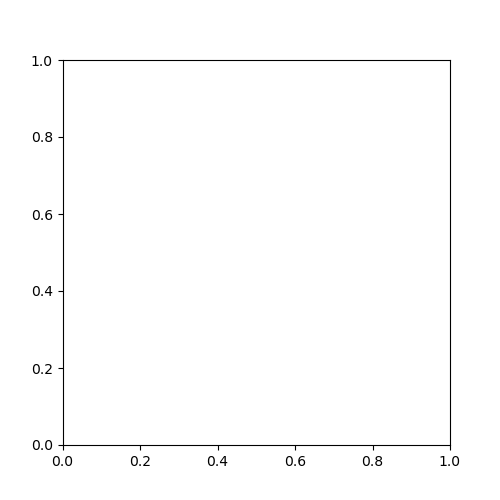

In [249]:
if __name__ == "__main__":
    Start_Pattern = np.loadtxt("FalseMinPatternStart3.csv", delimiter=",", dtype=int)
    A_mem = np.loadtxt("memory_pattern_A.csv", delimiter=",", dtype=int)
    B_mem = np.loadtxt("memory_pattern_B.csv", delimiter=",", dtype=int)
    C_mem = np.loadtxt("memory_pattern_C.csv", delimiter=",", dtype=int)
    D_mem = np.loadtxt("memory_pattern_D.csv", delimiter=",", dtype=int)
    FalseMin_1 = np.loadtxt("FalseMinPattern3.csv", delimiter=",",dtype=int) 
    FalseMin_2 = np.loadtxt("FalseMinPattern3-2.csv", delimiter=",",dtype=int) 
    
    AsPerT = []
    CsPerT = []
    FalsePerT1 = []
    FalsePerT2 = []
    OtherPerT = []
    T = np.arange(0.001, 5.001, 0.05)
    W = LoadMemory()
    
    for t in T: 

        Number_of_As = 0
        Number_of_Cs = 0
        Number_of_FalseMin1 = 0
        Number_of_FalseMin2 = 0
        Other = 0
        for _ in range(100):
            test = DAQMemoryNet(W, t, Start_Pattern)
            test.recall(6)
            if np.sum(test.start == A_mem) == 100:
                Number_of_As += 1
            elif np.sum(test.start == C_mem) == 100:
                Number_of_Cs += 1
            elif np.sum(test.start == FalseMin_1) == 100:
                Number_of_FalseMin1 += 1
            elif np.sum(test.start == FalseMin_2) == 100:
                Number_of_FalseMin2 += 1
            else:
                Other += 1
                
        AsPerT.append(Number_of_As)
        CsPerT.append(Number_of_Cs)
        FalsePerT1.append(Number_of_FalseMin1)
        FalsePerT2.append(Number_of_FalseMin2)
        OtherPerT.append(Other)



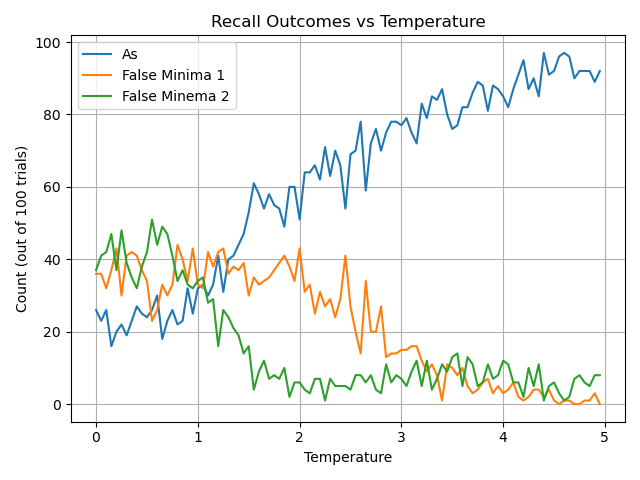

In [252]:
plt.close("all")
plt.plot(T, AsPerT, label='As')
#plt.plot(T, CsPerT, label='Cs')
plt.plot(T, FalsePerT1, label='False Minima 1')
#plt.plot(T, FalsePerT2, label='False Minima 2')
plt.plot(T, OtherPerT, label='False Minema 2')
plt.title("Recall Outcomes vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Count (out of 100 trials)")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("Recall Outcomes vs Temperature Scatter for start 3")
plt.show()  